In [2]:
from dataset.loader import SPOTS10
X_train, y_train, X_test, y_test = SPOTS10()

# Split the training data into training and validation data
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)


File dataset/test-images-idx3-ubyte.gz already exists, skipping download
File dataset/test-labels-idx1-ubyte.gz already exists, skipping download
File dataset/train-images-idx3-ubyte.gz already exists, skipping download
File dataset/train-labels-idx1-ubyte.gz already exists, skipping download
File utilities/spots_10_loader.py already exists, skipping download
All files downloaded successfully


In [3]:
import matplotlib.pyplot as plt
import numpy as np

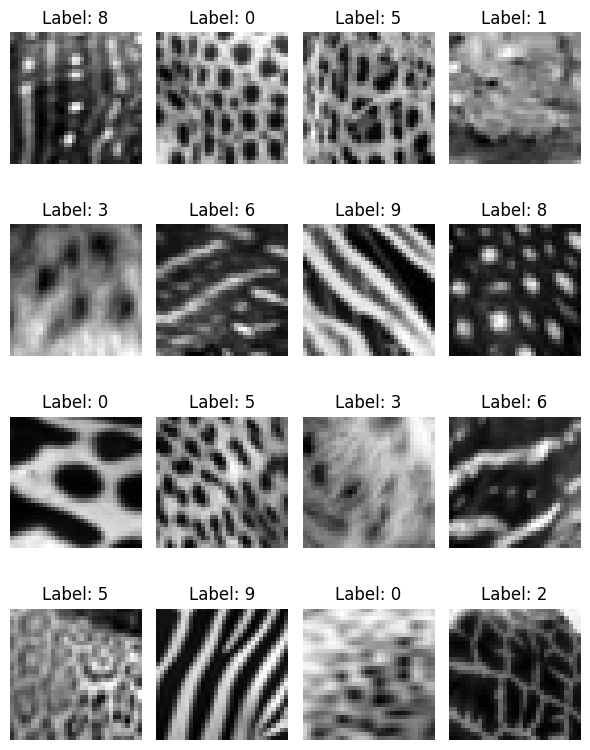

In [4]:
# Plot random sample images from X_train
num_rows = 4
num_cols = 4
num_samples = num_rows * num_cols
random_indices = np.random.choice(X_train.shape[0], num_samples, replace=False)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(1.5*num_cols, 2*num_rows))
for i, idx in enumerate(random_indices):
    ax = axes[i // num_cols, i % num_cols]
    ax.imshow(X_train[idx], cmap='gray')
    ax.set_title('Label: {}'.format(y_train[idx]))
    ax.axis('off')
plt.tight_layout()
plt.show()

In [5]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape

((36000, 32, 32), (36000,), (10000, 32, 32), (10000,), (4000, 32, 32), (4000,))

In [6]:
# Train a baseline fully connected neural network

import torch
import numpy as np

# The structure of the neural network: (32*32) -> 128 -> 64 -> 10
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = torch.nn.Linear(32*32, 128)
        self.fc2 = torch.nn.Linear(128, 64)
        self.fc3 = torch.nn.Linear(64, 10)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
# Convert the data to PyTorch tensors
X_train_tensor = torch.tensor(X_train).float()
y_train_tensor = torch.tensor(y_train).long()

X_test_tensor = torch.tensor(X_test).float()
y_test_tensor = torch.tensor(y_test).long()

X_val_tensor = torch.tensor(X_val).float()
y_val_tensor = torch.tensor(y_val).long()


# Transfer the data to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
X_train_tensor, y_train_tensor = X_train_tensor.to(device), y_train_tensor.to(device)
X_test_tensor, y_test_tensor = X_test_tensor.to(device), y_test_tensor.to(device)
X_val_tensor, y_val_tensor = X_val_tensor.to(device), y_val_tensor.to(device)

# Transform the data to PyTorch DataLoader
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=256, shuffle=True)

validation_dataset = torch.utils.data.TensorDataset(X_val_tensor, y_val_tensor)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=256, shuffle=False)

test_dataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=256, shuffle=False)

# Initialize the neural network
net = Net()
net.to(device)

# Print the neural network structure
print(net)
# Print the number of parameters in the neural network
print(sum(p.numel() for p in net.parameters()))

# Define the loss function and the optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-4)

# Train the neural network
num_epochs = 30
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = net(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    # Epoch summary (training and validation)
    net.eval()
    train_loss = 0
    train_accuracy = 0
    val_loss = 0
    val_accuracy = 0
    with torch.no_grad():
        for images, labels in train_loader:
            outputs = net(images)
            loss = criterion(outputs, labels)
            train_loss += loss.item()
            train_accuracy += (outputs.argmax(1) == labels).float().mean()
        for images, labels in validation_loader:
            outputs = net(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_accuracy += (outputs.argmax(1) == labels).float().mean()
    train_loss /= len(train_loader)
    train_accuracy /= len(train_loader)
    val_loss /= len(validation_loader)
    val_accuracy /= len(validation_loader)
    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')



Net(
  (fc1): Linear(in_features=1024, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)
140106
Epoch 1/30, Training Loss: 2.6604, Training Accuracy: 0.1487, Validation Loss: 2.6658, Validation Accuracy: 0.1551
Epoch 2/30, Training Loss: 2.3639, Training Accuracy: 0.1859, Validation Loss: 2.3852, Validation Accuracy: 0.1953
Epoch 3/30, Training Loss: 2.2250, Training Accuracy: 0.2148, Validation Loss: 2.2632, Validation Accuracy: 0.2179
Epoch 4/30, Training Loss: 2.1409, Training Accuracy: 0.2322, Validation Loss: 2.1883, Validation Accuracy: 0.2297
Epoch 5/30, Training Loss: 2.0818, Training Accuracy: 0.2544, Validation Loss: 2.1294, Validation Accuracy: 0.2493
Epoch 6/30, Training Loss: 2.0379, Training Accuracy: 0.2674, Validation Loss: 2.1064, Validation Accuracy: 0.2530
Epoch 7/30, Training Loss: 2.0082, Training Accuracy: 0.2801, Validation Loss: 2.0753, Validation Accuracy: 0.26

In [7]:
# Test the neural network on test_loader
net.eval()

with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the test images: {} %'.format(100 * correct / total))

Accuracy of the network on the test images: 32.66 %


In [8]:
# Train a larger fully connected neural network
# The structure of the neural network: (32*32) -> 512 -> 256 -> 128 -> 64 -> 10
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = torch.nn.Linear(32*32, 512)
        self.fc2 = torch.nn.Linear(512, 256)
        self.fc3 = torch.nn.Linear(256, 128)
        self.fc4 = torch.nn.Linear(128, 64)
        self.fc5 = torch.nn.Linear(64, 10)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = self.fc5(x)
        return x

# Initialize the neural network
net = Net()
net.to(device)

# Print the neural network structure
print(net)
# Print the number of parameters in the neural network
print(sum(p.numel() for p in net.parameters()))

# Define the loss function and the optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-4)

# Train the neural network
num_epochs = 30
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = net(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    # Epoch summary (training and validation)
    net.eval()
    train_loss = 0
    train_accuracy = 0
    val_loss = 0
    val_accuracy = 0
    with torch.no_grad():
        for images, labels in train_loader:
            outputs = net(images)
            loss = criterion(outputs, labels)
            train_loss += loss.item()
            train_accuracy += (outputs.argmax(1) == labels).float().mean()
        for images, labels in validation_loader:
            outputs = net(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_accuracy += (outputs.argmax(1) == labels).float().mean()
    train_loss /= len(train_loader)
    train_accuracy /= len(train_loader)
    val_loss /= len(validation_loader)
    val_accuracy /= len(validation_loader)
    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

Net(
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=64, bias=True)
  (fc5): Linear(in_features=64, out_features=10, bias=True)
)
697930
Epoch 1/30, Training Loss: 2.0215, Training Accuracy: 0.2405, Validation Loss: 2.0427, Validation Accuracy: 0.2292
Epoch 2/30, Training Loss: 1.9458, Training Accuracy: 0.2732, Validation Loss: 1.9830, Validation Accuracy: 0.2558
Epoch 3/30, Training Loss: 1.8680, Training Accuracy: 0.3056, Validation Loss: 1.9106, Validation Accuracy: 0.2847
Epoch 4/30, Training Loss: 1.8189, Training Accuracy: 0.3318, Validation Loss: 1.8762, Validation Accuracy: 0.3100
Epoch 5/30, Training Loss: 1.7704, Training Accuracy: 0.3477, Validation Loss: 1.8391, Validation Accuracy: 0.3172
Epoch 6/30, Training Loss: 1.7303, Training Accuracy: 0.3732, Validation Loss: 1.8239, Validation Accur

In [9]:
# Test the neural network on test_loader
net.eval()

with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the test images: {} %'.format(100 * correct / total))

Accuracy of the network on the test images: 40.02 %


In [10]:
# Train a convolutional neural network
# The structure of the neural network: (32*32) -> Conv1 -> MaxPool -> Conv2 -> MaxPool -> 128 -> 64 -> 10
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 32, kernel_size=5)
        self.conv2 = torch.nn.Conv2d(32, 64, kernel_size=5)
        self.fc1 = torch.nn.Linear(64*5*5, 128)
        self.fc2 = torch.nn.Linear(128, 64)
        self.fc3 = torch.nn.Linear(64, 10)
    
    def forward(self, x):
        x = x.view(-1, 1, 32, 32)
        x = torch.relu(self.conv1(x)) # 32x(28x28)
        x = torch.max_pool2d(x, kernel_size=2) # 32x(14x14)
        x = torch.relu(self.conv2(x)) # 64x(10x10)
        x = torch.max_pool2d(x, kernel_size=2) # 64x(5x5)
        x = torch.flatten(x, 1) # 1600
        x = torch.relu(self.fc1(x)) # 128
        x = torch.relu(self.fc2(x)) # 64
        x = self.fc3(x) # 10
        return x
    
# Initialize the neural network
net = Net()
net.to(device)

# Print the neural network structure
print(net)
# Print the number of parameters in the neural network
print(sum(p.numel() for p in net.parameters()))

# Define the loss function and the optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-4)

# Train the neural network
num_epochs = 30
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = net(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    # Epoch summary (training and validation)
    net.eval()
    train_loss = 0
    train_accuracy = 0
    val_loss = 0
    val_accuracy = 0
    with torch.no_grad():
        for images, labels in train_loader:
            outputs = net(images)
            loss = criterion(outputs, labels)
            train_loss += loss.item()
            train_accuracy += (outputs.argmax(1) == labels).float().mean()
        for images, labels in validation_loader:
            outputs = net(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_accuracy += (outputs.argmax(1) == labels).float().mean()
    train_loss /= len(train_loader)
    train_accuracy /= len(train_loader)
    val_loss /= len(validation_loader)
    val_accuracy /= len(validation_loader)
    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=1600, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)
265930
Epoch 1/30, Training Loss: 1.7702, Training Accuracy: 0.3804, Validation Loss: 1.7831, Validation Accuracy: 0.3677
Epoch 2/30, Training Loss: 1.3522, Training Accuracy: 0.5199, Validation Loss: 1.3780, Validation Accuracy: 0.5094
Epoch 3/30, Training Loss: 1.0533, Training Accuracy: 0.6296, Validation Loss: 1.0902, Validation Accuracy: 0.6217
Epoch 4/30, Training Loss: 0.9067, Training Accuracy: 0.6905, Validation Loss: 0.9570, Validation Accuracy: 0.6629
Epoch 5/30, Training Loss: 0.8340, Training Accuracy: 0.7090, Validation Loss: 0.8944, Validation Accuracy: 0.6767
Epoch 6/30, Training Loss: 0.8255, Training Accuracy: 0.7078, Validation Loss: 0.8991, Validation Accuracy

In [11]:
# Test the neural network on test_loader
net.eval()

with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the test images: {} %'.format(100 * correct / total))

Accuracy of the network on the test images: 72.89 %


In [12]:
# Would a smaller convolutional neural network be enough?
# The structure of the neural network: (32*32) -> Conv1 -> MaxPool 
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 8, kernel_size=5)
        self.conv2 = torch.nn.Conv2d(8, 16, kernel_size=3)
        self.conv3 = torch.nn.Conv2d(16, 16, kernel_size=3)
        self.fc1 = torch.nn.Linear(16*2*2, 32)
        self.fc2 = torch.nn.Linear(32, 10)
        

    def forward(self, x):
        x = x.view(-1, 1, 32, 32)
        x = torch.relu(self.conv1(x)) # 8x(28x28)
        x = torch.max_pool2d(x, kernel_size=2) # 8x(14x14)
        x = torch.relu(self.conv2(x)) # 16x(12x12)
        x = torch.max_pool2d(x, kernel_size=2) # 16x(6x6)
        x = torch.relu(self.conv3(x)) # 32x(4x4)
        x = torch.max_pool2d(x, kernel_size=2) # 32x(2x2)
        x = torch.flatten(x, 1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
# Initialize the neural network
net = Net()
net.to(device)

# Print the neural network structure
print(net)
# Print the number of parameters in the neural network
print(sum(p.numel() for p in net.parameters()))

# Define the loss function and the optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

# Train the neural network
num_epochs = 15
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = net(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    # Epoch summary (training and validation)
    net.eval()
    train_loss = 0
    train_accuracy = 0
    val_loss = 0
    val_accuracy = 0
    with torch.no_grad():
        for images, labels in train_loader:
            outputs = net(images)
            loss = criterion(outputs, labels)
            train_loss += loss.item()
            train_accuracy += (outputs.argmax(1) == labels).float().mean()
        for images, labels in validation_loader:
            outputs = net(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_accuracy += (outputs.argmax(1) == labels).float().mean()
    train_loss /= len(train_loader)
    train_accuracy /= len(train_loader)
    val_loss /= len(validation_loader)
    val_accuracy /= len(validation_loader)
    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

Net(
  (conv1): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=10, bias=True)
)
6106
Epoch 1/15, Training Loss: 1.5469, Training Accuracy: 0.4393, Validation Loss: 1.5376, Validation Accuracy: 0.4312
Epoch 2/15, Training Loss: 1.2968, Training Accuracy: 0.5279, Validation Loss: 1.2966, Validation Accuracy: 0.5168
Epoch 3/15, Training Loss: 1.0764, Training Accuracy: 0.6182, Validation Loss: 1.0839, Validation Accuracy: 0.6067
Epoch 4/15, Training Loss: 0.9773, Training Accuracy: 0.6485, Validation Loss: 0.9994, Validation Accuracy: 0.6370
Epoch 5/15, Training Loss: 0.9167, Training Accuracy: 0.6700, Validation Loss: 0.9462, Validation Accuracy: 0.6557
Epoch 6/15, Training Loss: 0.8923, Training Accuracy: 0.6753, Validation Loss: 0.9434, Validation Accuracy: 0.651

In [13]:
# Test the neural network on test_loader
net.eval()

with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the test images: {} %'.format(100 * correct / total))

Accuracy of the network on the test images: 72.15 %
